In [2]:
# Required libraries
import dowhy
from dowhy import CausalModel
import dowhy.datasets

# Avoiding unnecessary log messges and warnings
import logging
logging.getLogger("dowhy").setLevel(logging.WARNING)
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

# Load some sample data
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_samples=10000,
    treatment_is_binary=True,
    stddev_treatment_noise=10)

In [3]:
# I. Create a causal model from the data and domain knowledge.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"])

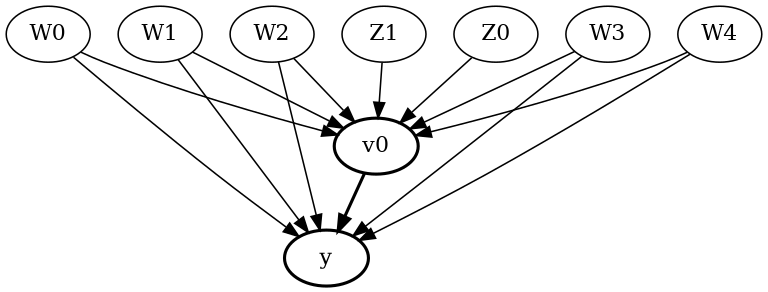

In [4]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [4]:
# I. Create a causal model from the data and given graph.
model = CausalModel(
    data=data["df"],
    treatment=data["treatment_name"][0],
    outcome=data["outcome_name"][0],
    graph=data["gml_graph"])
model.view_model(layout="dot")

In [5]:
# II. Identify causal effect and return target estimands
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W4,W1,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [6]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W4,W1,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2
Target units: ate

## Estimate
Mean value: 10.08764011184918



In [7]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand,
                                    method_name="backdoor.econml.dml.DML",
                                    method_params={
                                        'init_params': {'model_y':GradientBoostingRegressor(),
                                                        'model_t': GradientBoostingRegressor(),
                                                        'model_final':LassoCV(fit_intercept=False), },
                                        'fit_params': {}
                                     })
print(dml_estimate)

/home/rixile/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W0,W4,W1,W3,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W4,W1,W3,W2,U) = P(y|v0,W0,W4,W1,W3,W2)

## Realized estimand
b: y~v0+W0+W4+W1+W3+W2 | 
Target units: ate

## Estimate
Mean value: 9.985463739463857
Effect estimates: [9.98546374 9.98546374 9.98546374 ... 9.98546374 9.98546374 9.98546374]



In [ ]:
# IV. Refute the obtained estimate using multiple robustness checks.
refute_results = model.refute_estimate(identified_estimand, propensity_strat_estimate,
                                       method_name="placebo_treatment_refuter")
print(refute_results)